In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

In [3]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from io import StringIO
from IPython.display import Image  
import pydotplus

from sklearn.model_selection import cross_validate, cross_val_score

In [4]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [5]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0) # * data['result_prop']

In [6]:
mask = data[['allies_infantry', 'axis_infantry']].isnull().any(1)

In [7]:
data=data[~mask]

In [8]:
cols_to_fill = ['allies_planes', 'axis_planes', 'axis_tanks', 'allies_tanks', 'axis_guns', 'allies_guns']
mask_null = data[cols_to_fill].isnull()
data[cols_to_fill] = data[cols_to_fill].fillna(0)

In [9]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month
data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

In [10]:
cols = [
    'allies_infantry', 'axis_infantry', 'allies_tanks', 'axis_tanks', 
    'allies_planes', 'axis_planes', 'duration'
]

## Models

In [36]:
model1 = DecisionTreeClassifier(random_state=2019, max_depth=10)

In [37]:
cv = cross_validate(model1,
                    data[cols], 
                    data['result_num'],
                    cv=4)

cv = pd.DataFrame(cv)
cv

,fit_time,score_time,test_score,train_score
0,0.003353,0.003298,0.409091,1.000000
1,0.003815,0.001473,0.523810,0.984127
2,0.006358,0.003581,0.523810,1.000000
3,0.005178,0.004309,0.600000,0.968750


In [38]:
cv['test_score'].mean()

0.5141774891774892

# Feature Engineering

#### Army size comparison

In [39]:
data['infantry_ratio'] = data['allies_infantry'] / data['axis_infantry']
cols.append('infantry_ratio')

for tp in 'infantry', 'planes', 'tanks', 'guns':
    data[f'{tp}_diff'] = data[f'allies_{tp}'] - data[f'axis_{tp}']
    cols.append(f'{tp}_diff')

In [40]:
scores = cross_val_score(model1, 
                         data[cols], 
                         data['result_num'],
                         cv=4)
pd.np.mean(scores)

0.49886363636363634

In [41]:
scores

array([0.54545455, 0.47619048, 0.52380952, 0.45      ])

# leaders

In [42]:
from collections import Counter

In [43]:
def _generate_binary_most_common(col, N=10):
    mask = col.notnull()
    lead_list = [ el.strip() for _, cell in col[mask].iteritems() for el in cell if el != '']
    c = Counter(lead_list)
    
    mc = c.most_common(N)
    df = pd.DataFrame(index=col.index, columns=[name[0] for name in mc])
    
    for name in df.columns:
        df.loc[mask, name] = col[mask].apply(lambda x: name in x).astype(int)
    return df.fillna(0)
    
    
    

In [44]:
axis_pop = _generate_binary_most_common(data['axis_leaders'].str.split(','), N=2)
allies_pop = _generate_binary_most_common(data['allies_leaders'].str.split(','), N=2)

In [45]:
data2 = pd.concat([data, axis_pop, allies_pop], axis=1)

In [46]:
cols2 = cols + axis_pop.columns.tolist() + allies_pop.columns.tolist()

In [47]:
model2 = DecisionTreeClassifier(random_state=2019, max_depth=15)

In [48]:
scores = cross_val_score(model1, 
                         data2[cols2], 
                         data2['result_num'],
                         cv=4)
pd.np.mean(scores)

0.4767316017316017

### Belligerents

In [49]:
data2['belligerents.allies']

0                                                 Poland
4                                                 Poland
6                                                 Poland
8                                                 Poland
9                                                 Poland
10                                       Polish Republic
11                                                Poland
12                                                Poland
13                                                Poland
14                                                Poland
15                                          Soviet Union
17                                          Soviet Union
18                                          Soviet Union
19                                               Finland
20                                               Finland
21                                               Finland
22                                               Finland
23                             

In [50]:
scores = cross_val_score(model1, 
                         data2[cols2], 
                         data2['result_num'],
                         cv=4)
pd.np.mean(scores)

0.4767316017316017

## Hyper-parameter optimisation

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [52]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(5, 20),
              "max_features": sp_randint(1, len(cols2)),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]}

In [53]:
rs = RandomizedSearchCV(
    model1,
    param_distributions=param_dist,
    cv=4, iid=False,
    random_state=2019,
    n_iter=50
)

In [54]:
rs.fit(data2[cols2], data2['result_num'])

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2019,
            splitter='best'),
          fit_params=None, iid=False, n_iter=50, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11857f978>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11857f7b8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1185c4e48>, 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=2019, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [55]:
rs.best_score_

0.6430735930735931

In [56]:
rs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            presort=False, random_state=2019, splitter='best')

# Visualize the graph

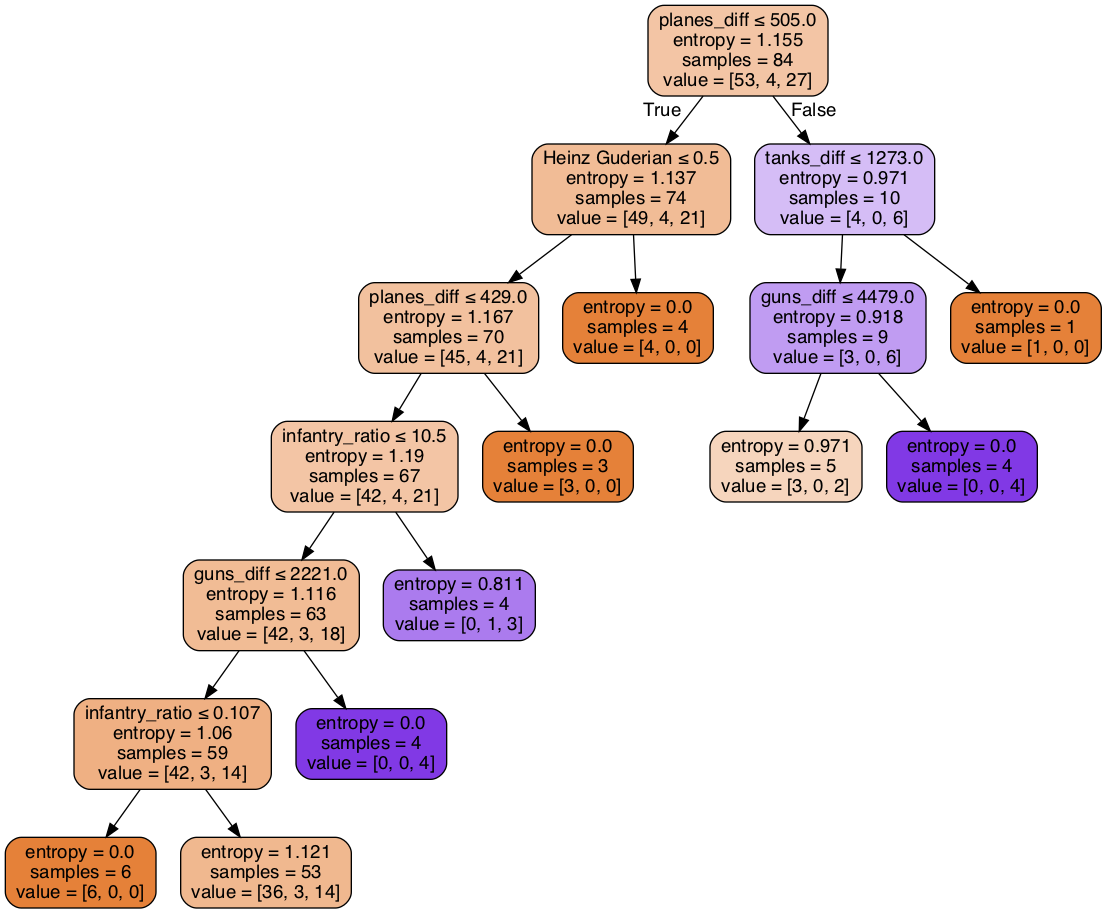

In [57]:
dot_data = StringIO()

export_graphviz(rs.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=cols2)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Storing tree chart to a file

# Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
rf = RandomForestClassifier(random_state=2019)

In [60]:
scores = cross_val_score(rf, 
                         data2[cols2], 
                         data2['result_num'],
                         cv=4)
pd.np.mean(scores)

0.5

In [61]:
param_dist2 = {
              'n_estimators': sp_randint(50, 2000),
              "max_depth": sp_randint(5, 25),
              "max_features": sp_randint(1, len(cols2)),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]
}

In [62]:
rs2 = RandomizedSearchCV(
    rf,
    param_distributions=param_dist2,
    cv=4, iid=False,
    random_state=2019,
    n_iter=50
)

In [63]:
rs2.fit(data2[cols2], data2['result_num'])

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False),
          fit_params=None, iid=False, n_iter=50, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1187d34e0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1187d3748>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1187d3a90>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1187d3b38>, 'criterion': ['gini', 'entropy']},
          pre_dispatch=

In [64]:
rs2.best_score_

0.5970779220779221

In [65]:
data2[cols2]

,allies_infantry,axis_infantry,allies_tanks,axis_tanks,allies_planes,axis_planes,duration,infantry_ratio,infantry_diff,planes_diff,...,guns_diff,infantry_ratio,infantry_diff,planes_diff,tanks_diff,guns_diff,Erich von Manstein,Heinz Guderian,Leonid Govorov,Ivan Konev
0,240.0,3400.0,0.0,0.0,0.0,60.0,1,0.070588,-3160.0,-60.0,...,0.0,0.070588,-3160.0,-60.0,0.0,0.0,0,0,0,0
4,50000.0,5000.0,58.0,498.0,0.0,0.0,1,10.000000,45000.0,0.0,...,-93.0,10.000000,45000.0,0.0,-440.0,-93.0,0,0,0,0
6,720.0,42200.0,0.0,350.0,0.0,0.0,1,0.017062,-41480.0,0.0,...,-651.0,0.017062,-41480.0,0.0,-350.0,-651.0,0,1,0,0
8,2800.0,38000.0,0.0,0.0,0.0,0.0,1,0.073684,-35200.0,0.0,...,46.0,0.073684,-35200.0,0.0,0.0,46.0,0,0,0,0
9,225000.0,425000.0,0.0,500.0,0.0,0.0,1,0.529412,-200000.0,0.0,...,0.0,0.529412,-200000.0,0.0,-500.0,0.0,0,0,0,0
10,124000.0,175000.0,0.0,0.0,0.0,0.0,1,0.708571,-51000.0,0.0,...,0.0,0.708571,-51000.0,0.0,0.0,0.0,0,0,0,0
11,8800.0,175000.0,0.0,200.0,0.0,0.0,1,0.050286,-166200.0,0.0,...,30.0,0.050286,-166200.0,0.0,-200.0,30.0,0,0,0,0
12,70000.0,45000.0,400.0,800.0,0.0,0.0,1,1.555556,25000.0,0.0,...,0.0,1.555556,25000.0,0.0,-400.0,0.0,0,0,0,0
13,22500.0,20000.0,0.0,0.0,0.0,0.0,1,1.125000,2500.0,0.0,...,0.0,1.125000,2500.0,0.0,0.0,0.0,0,0,0,0
14,18000.0,30000.0,0.0,400.0,0.0,0.0,1,0.600000,-12000.0,0.0,...,0.0,0.600000,-12000.0,0.0,-400.0,0.0,0,0,0,0
